In [2]:
import pandas as pd

ds_names = [1,2,5,6,14,16,104]

train_samples = {}
test_samples = {}

months = ['nov', 'mar', 'jul']
for month in months:
    for ds_name in ds_names:
        for i in range(1, 3):
            try:
                f_name = f'../data/{month}_samples/dataset_{ds_name}_season_{i}.csv' 
                if ds_name != 1:
                    train_samples[f'{month}_{ds_name}_{i}'] = pd.read_csv(f_name)
                else:
                    test_samples[f'{month}_{ds_name}_{i}'] = pd.read_csv(f_name)
            except Exception as e:
                print(e)
                continue

[Errno 2] No such file or directory: '../data/nov_samples/dataset_14_season_2.csv'
[Errno 2] No such file or directory: '../data/nov_samples/dataset_104_season_2.csv'
[Errno 2] No such file or directory: '../data/mar_samples/dataset_14_season_2.csv'
[Errno 2] No such file or directory: '../data/mar_samples/dataset_104_season_2.csv'
[Errno 2] No such file or directory: '../data/jul_samples/dataset_14_season_2.csv'
[Errno 2] No such file or directory: '../data/jul_samples/dataset_16_season_1.csv'
[Errno 2] No such file or directory: '../data/jul_samples/dataset_16_season_2.csv'
[Errno 2] No such file or directory: '../data/jul_samples/dataset_104_season_1.csv'
[Errno 2] No such file or directory: '../data/jul_samples/dataset_104_season_2.csv'


## as X and y 

In [ ]:
# test_ids = ['1_2', '5_2']
# test_samples = {name: data for name, data in data_samples.items() if name in test_ids}
# train_samples = {name: data for name, data in data_samples.items() if name not in test_ids}

In [3]:
train_samples.keys(), test_samples.keys()

(dict_keys(['nov_2_1', 'nov_2_2', 'nov_5_1', 'nov_5_2', 'nov_6_1', 'nov_6_2', 'nov_14_1', 'nov_16_1', 'nov_16_2', 'nov_104_1', 'mar_2_1', 'mar_2_2', 'mar_5_1', 'mar_5_2', 'mar_6_1', 'mar_6_2', 'mar_14_1', 'mar_16_1', 'mar_16_2', 'mar_104_1', 'jul_2_1', 'jul_2_2', 'jul_5_1', 'jul_5_2', 'jul_6_1', 'jul_6_2', 'jul_14_1']),
 dict_keys(['nov_1_1', 'nov_1_2', 'mar_1_1', 'mar_1_2', 'jul_1_1', 'jul_1_2']))

### funcs

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Concatenate, Flatten, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Data Preparation and Feature Engineering
# def create_date_features(length, start_date='2020-01-01'):
def create_date_features(dates_series): 
    """Generate relative date features with cyclical encoding"""
    df = pd.DataFrame(index=dates_series)
    
    # Cyclical features
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    
    # Cyclical encoding using sine/cosine
    for feature, period in [('day_of_week', 7), ('month', 12), ('day_of_year', 365)]:
        df[f'{feature}_sin'] = np.sin(2 * np.pi * df[feature] / period)
        df[f'{feature}_cos'] = np.cos(2 * np.pi * df[feature] / period)
    
    return df.drop(columns=['day_of_week', 'month', 'day_of_year']).values

def preprocess_samples(samples_dict, data_scaler=None, y_scaler=None, fit_scalers=True):
    """Preprocess samples into X_data, X_dates, y with optional scaling"""
    X_data, X_dates, y = [], [], []
    
    for name, df in samples_dict.items(): 
        name = name.split('_')[1]
        values = df[name].values
        dates_series = pd.to_datetime(df['full_date'])

        # Split into X (245) and y (120)
        X_data.append(values[:245])
        y.append(values[245:])
        print(values.shape)
        # Create date features
        date_features_all = create_date_features(dates_series) # <- Add this
        X_dates.append(date_features_all[245:])
    
    # Convert to numpy arrays
    X_data = np.array(X_data)[..., np.newaxis]  # Add channel dimension
    print(X_dates[0].shape)
    X_dates = np.array(X_dates)
    y = np.array(y)
    
    # Scaling
    if fit_scalers:
        data_scaler = StandardScaler()
        y_scaler = StandardScaler()
        
        # Reshape for scaling
        X_data_flat = X_data.reshape(-1, 1) # Reshape for scaling
        data_scaler.fit(X_data_flat)
        y_scaler.fit(y)
    
    # X_data_scaled = data_scaler.transform(X_data.reshape(-1, 245)).reshape(X_data.shape)
    X_data_flat = X_data.reshape(-1, 1)
    X_data_scaled_flat = data_scaler.transform(X_data_flat)
    X_data_scaled = X_data_scaled_flat.reshape(X_data.shape)
    y_scaled = y_scaler.transform(y)
    
    return (X_data_scaled, X_dates, y_scaled), data_scaler, y_scaler

# 2. Model Architectures
def create_mlp_model(data_shape, dates_shape):
    """Create MLP model with two input branches"""
    # Data input branch
    data_input = Input(shape=data_shape)
    flat_data = Flatten()(data_input)
    
    # Dates input branch
    dates_input = Input(shape=dates_shape)
    flat_dates = Flatten()(dates_input)
    
    # Combined model
    merged = Concatenate()([flat_data, flat_dates])
    x = Dense(256, activation='relu')(merged)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(120)(x)
    
    model = Model(inputs=[data_input, dates_input], outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def create_lstm_model(data_shape, dates_shape):
    """Create LSTM model with two input branches"""
    # Data input branch
    data_input = Input(shape=data_shape)
    x = LSTM(64, return_sequences=True)(data_input)
    x = LSTM(32)(x)
    
    # Dates input branch
    dates_input = Input(shape=dates_shape)
    y = LSTM(32)(dates_input)
    
    # Combined model
    merged = Concatenate()([x, y])
    z = Dense(64, activation='relu')(merged)
    outputs = Dense(120)(z)
    
    model = Model(inputs=[data_input, dates_input], outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


# 4. Evaluation
def evaluate_model(model, X_data, X_dates, y_true_scaled, y_scaler):
    """
    Evaluates the model, calculates MSE, MAE, MAPE, and returns metrics
    along with unscaled predictions and true values.
    """
    y_pred_scaled = model.predict([X_data, X_dates])

    # Inverse transform to original scale
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_true_scaled) # Use the scaled y_true input

    # --- Calculate Metrics ---
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))

    # Calculate MAPE, adding epsilon to avoid division by zero
    epsilon = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

    metrics = {'mse': mse, 'mae': mae, 'mape': mape}

    return metrics, y_true, y_pred

# 5. Plotting Predictions vs Actuals

def plot_predictions(X_data_scaled, data_scaler, y_true, y_pred, model_name, num_samples_to_plot=3):
    """Plots input history, true future, and predicted future"""
    num_samples_total = X_data_scaled.shape[0]
    num_samples_to_plot = min(num_samples_to_plot, num_samples_total)
    if num_samples_to_plot <= 0:
        print("No samples to plot.")
        return

    input_len = X_data_scaled.shape[1] # Should be 245
    output_len = y_true.shape[1]       # Should be 120

    # Inverse scale the input data (X) for plotting in original scale
    X_data_unscaled = data_scaler.inverse_transform(X_data_scaled.reshape(-1, 1)).reshape(X_data_scaled.shape)


    plt.figure(figsize=(15, num_samples_to_plot * 5))
    plt.suptitle(f'{model_name} - Predictions vs Actuals', fontsize=16, y=1.02)

    for i in range(num_samples_to_plot):
        sample_idx = i # Plot the first few samples

        plt.subplot(num_samples_to_plot, 1, i + 1)

        # Time axes
        input_time = np.arange(input_len)
        output_time = np.arange(input_len, input_len + output_len)

        # Plotting
        plt.plot(input_time, X_data_unscaled[sample_idx, :, 0], 'k-', label='Input History (Unscaled)', alpha=0.7)
        plt.plot(output_time, y_true[sample_idx, :], 'bo-', label='True Future', markersize=4)
        plt.plot(output_time, y_pred[sample_idx, :], 'ro--', label='Predicted Future', markersize=4)

        plt.title(f'Test Sample {sample_idx + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.layers import Conv1D, MaxPooling1D, GRU, Bidirectional


# Modified Data Preparation for Traditional Models
def prepare_traditional_data(X_data, X_dates):
    """Flatten data for traditional ML models"""
    # Flatten time series data and date features
    X_flat = np.concatenate([
        X_data.reshape(X_data.shape[0], -1),  # Flatten time series (245,1) -> 245
        X_dates.reshape(X_dates.shape[0], -1) # Flatten dates (120,6) -> 720
    ], axis=1)
    return X_flat

# 5. Traditional Model Implementations
def train_traditional_models(X_train, y_train):
    """Train various traditional models with MultiOutputRegressor"""
    models = {
        'SVR': MultiOutputRegressor(SVR(kernel='rbf', C=1.0, epsilon=0.1)),
        'SGD': MultiOutputRegressor(SGDRegressor(max_iter=1000, tol=1e-3)),
        'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
        'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, 
                                     loss_function='MultiRMSE', verbose=0)
    }
    
    trained_models = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
        print(f"{name} training complete")
    
    return trained_models

# 6. New Neural Network Architectures
def create_cnn_model(data_shape, dates_shape):
    """1D CNN model with date features"""
    # Time series input
    ts_input = Input(shape=data_shape)
    x = Conv1D(64, 3, activation='relu')(ts_input)
    x = MaxPooling1D(2)(x)
    x = Conv1D(32, 3, activation='relu')(x)
    x = Flatten()(x)
    
    # Date features input
    date_input = Input(shape=dates_shape)
    y = Flatten()(date_input)
    
    # Combined
    merged = Concatenate()([x, y])
    z = Dense(128, activation='relu')(merged)
    outputs = Dense(120)(z)
    
    model = Model(inputs=[ts_input, date_input], outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def create_bigru_model(data_shape, dates_shape):
    """Bidirectional GRU model with attention"""
    # Time series input
    ts_input = Input(shape=data_shape)
    x = Bidirectional(GRU(64, return_sequences=True))(ts_input)
    x = Bidirectional(GRU(32))(x)
    
    # Date features input
    date_input = Input(shape=dates_shape)
    y = LSTM(32)(date_input)
    
    # Combined
    merged = Concatenate()([x, y])
    z = Dense(64, activation='relu')(merged)
    outputs = Dense(120)(z)
    
    model = Model(inputs=[ts_input, date_input], outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# 7. Enhanced Evaluation Function
def evaluate_traditional_model(model, X_flat, y_true_scaled, y_scaler, model_name):
    """Evaluation function for traditional models"""
    y_pred_scaled = model.predict(X_flat)
    
    # Inverse scaling
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_true_scaled)
    
    # Calculate metrics
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print_result(model_name, mse, mae, mape, y_true, y_pred)
    
    return y_pred

### train, test init

In [14]:
# Example structure:
# train_samples = {'sample1': np.random.randn(365), ...}
# test_samples = {'test1': np.random.randn(365), ...}

# Preprocess training data
(X_train_data, X_train_dates, y_train), data_scaler, y_scaler = preprocess_samples(train_samples)

# Preprocess test data using training scalers
(X_test_data, X_test_dates, y_test), _, _ = preprocess_samples(
    test_samples, data_scaler=data_scaler, y_scaler=y_scaler, fit_scalers=False
)

# Model parameters
data_shape = (245, 1)
dates_shape = (122, X_train_dates.shape[-1])

early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Prepare traditional model data
X_train_flat = prepare_traditional_data(X_train_data, X_train_dates)
X_test_flat = prepare_traditional_data(X_test_data, X_test_dates)


def print_result(model_name, mse, mae, mape, y_true, y_pred):
    print(f"{model_name} Test Metrics: MSE={mse:.4f}, MAE={mae:.4f}, MAPE={mape:.2f}%")
    if not mape > 35:
        plot_predictions(X_test_data, data_scaler, y_true, y_pred, model_name)

def evaluate_traditional_model(model, X_flat, y_true_scaled, y_scaler, model_name):
    """Evaluation function for traditional models"""
    y_pred_scaled = model.predict(X_flat)
    
    # Inverse scaling
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_true_scaled)
    
    # Calculate metrics
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print_result(model_name, mse, mae, mape, y_true, y_pred)
    
    return y_pred

(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(365,)
(365,)
(365,)
(365,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(367,)
(122, 6)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (27,) + inhomogeneous part.

In [193]:
import joblib

model_filename = f'{month}_scalers_data.joblib'
model_folder = '../models_seq2seq/'

# Save the TRAINED model object to the file
print(f"Saving model to {model_filename}...")
joblib.dump((data_scaler, y_scaler), model_folder+model_filename)
print("Model saved successfully.")

Saving model to jul_scalers_data.joblib...
Model saved successfully.


In [161]:
X_train_data.shape

(6, 245, 1)

In [162]:
X_train_flat.shape

(6, 965)

### nns

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.4440 - val_loss: 1.0481
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.1178 - val_loss: 1.1228
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.1038 - val_loss: 1.1436
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 1.0477 - val_loss: 1.1379
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 1.0060 - val_loss: 1.1278
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.9993 - val_loss: 1.1362
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.9694 - val_loss: 1.1460
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.9665 - val_loss: 1.1507
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.9612 - val_loss: 1.1507
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.9447 - val_loss: 1.1543
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.8959 - val_loss: 1.1584
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 1.0164 -

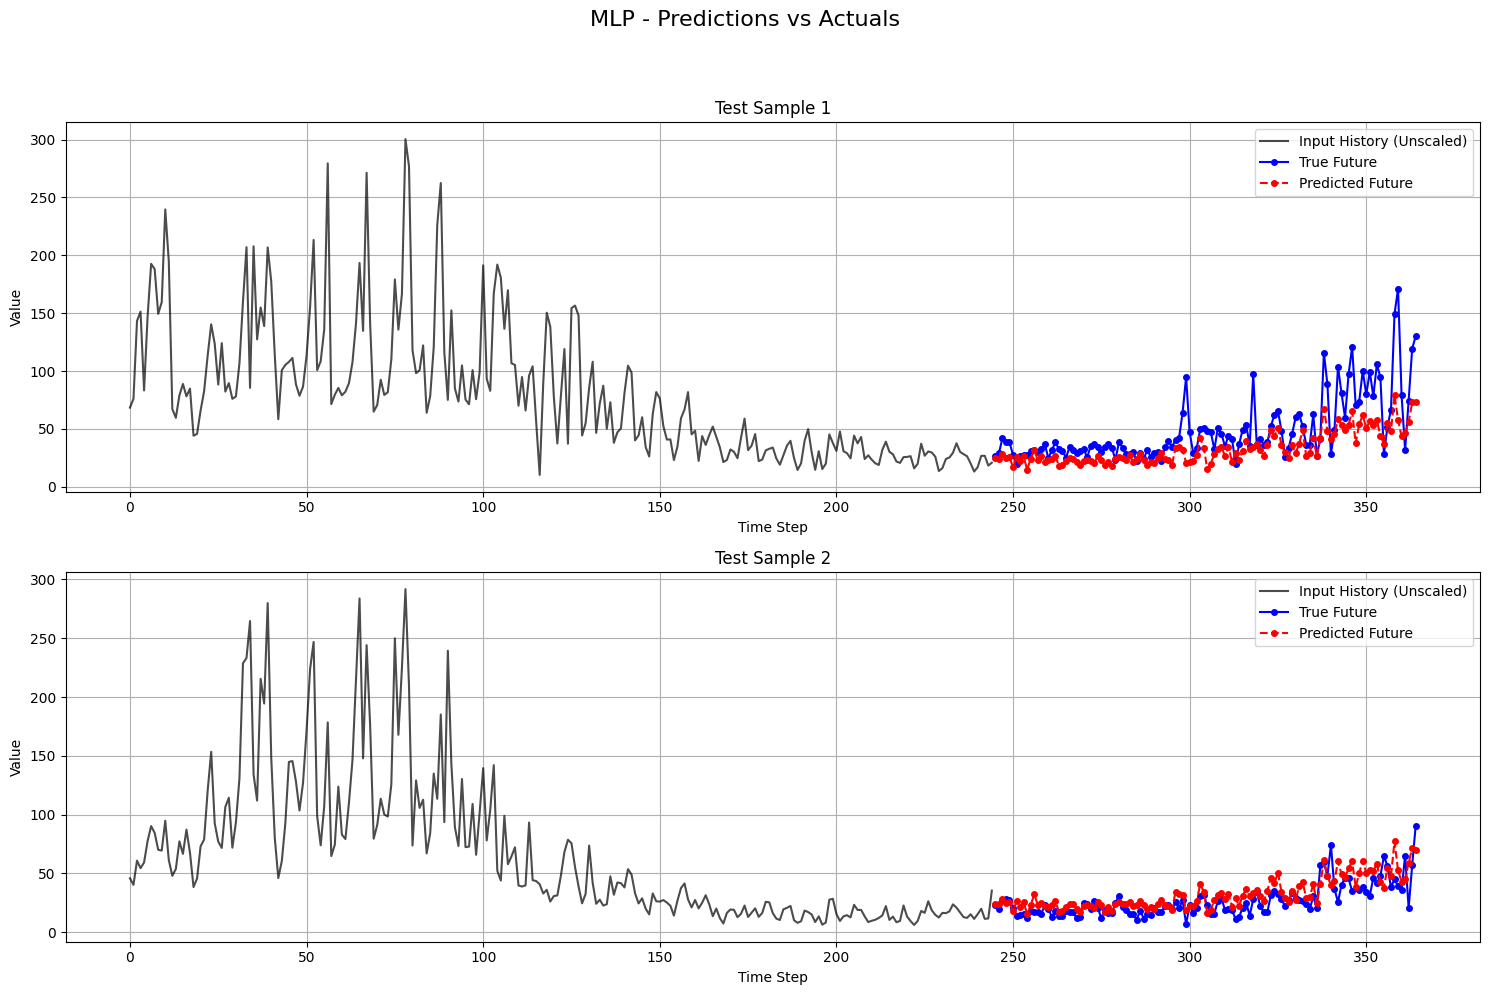

In [163]:
# Create and train MLP
mlp_model = create_mlp_model(data_shape, dates_shape)
mlp_model.fit(
    [X_train_data, X_train_dates], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# Create and train LSTM
lstm_model = create_lstm_model(data_shape, dates_shape)
lstm_model.fit(
    [X_train_data, X_train_dates], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# Evaluate on test set
mlp_metrics, y_true_mlp, y_pred_mlp = evaluate_model(
    mlp_model, X_test_data, X_test_dates, y_test, y_scaler
)
print(f"MLP Test Metrics: MSE={mlp_metrics['mse']:.4f}, MAE={mlp_metrics['mae']:.4f}, MAPE={mlp_metrics['mape']:.2f}%")

# Evaluate LSTM on test set
lstm_metrics, y_true_lstm, y_pred_lstm = evaluate_model(
    lstm_model, X_test_data, X_test_dates, y_test, y_scaler
)
# Note: y_true_mlp and y_true_lstm will be identical since they are derived from the same y_test_scaled
print(f"LSTM Test Metrics: MSE={lstm_metrics['mse']:.4f}, MAE={lstm_metrics['mae']:.4f}, MAPE={lstm_metrics['mape']:.2f}%")

# --- Generate Plots ---
print("\n--- Generating Prediction Plots ---")

# Plot MLP results
if mlp_metrics['mape'] < 35:
    plot_predictions(X_test_data, data_scaler, y_true_mlp, y_pred_mlp, "MLP")
if lstm_metrics['mape'] < 35:
    plot_predictions(X_test_data, data_scaler, y_true_lstm, y_pred_lstm, "LSTM")

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.1160 - val_loss: 1.3094
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 1.0020 - val_loss: 1.3237
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.9547 - val_loss: 1.2987
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.9320 - val_loss: 1.2754
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.9062 - val_loss: 1.2558
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.8837 - val_loss: 1.2475
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.8641 - val_loss: 1.2574
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.8391 - val_loss: 1.2651
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.8103 - val_loss: 1.2711
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.7810 - val_loss: 1.2647
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.7522 - val_loss: 1.2721
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.7218 - val_loss:

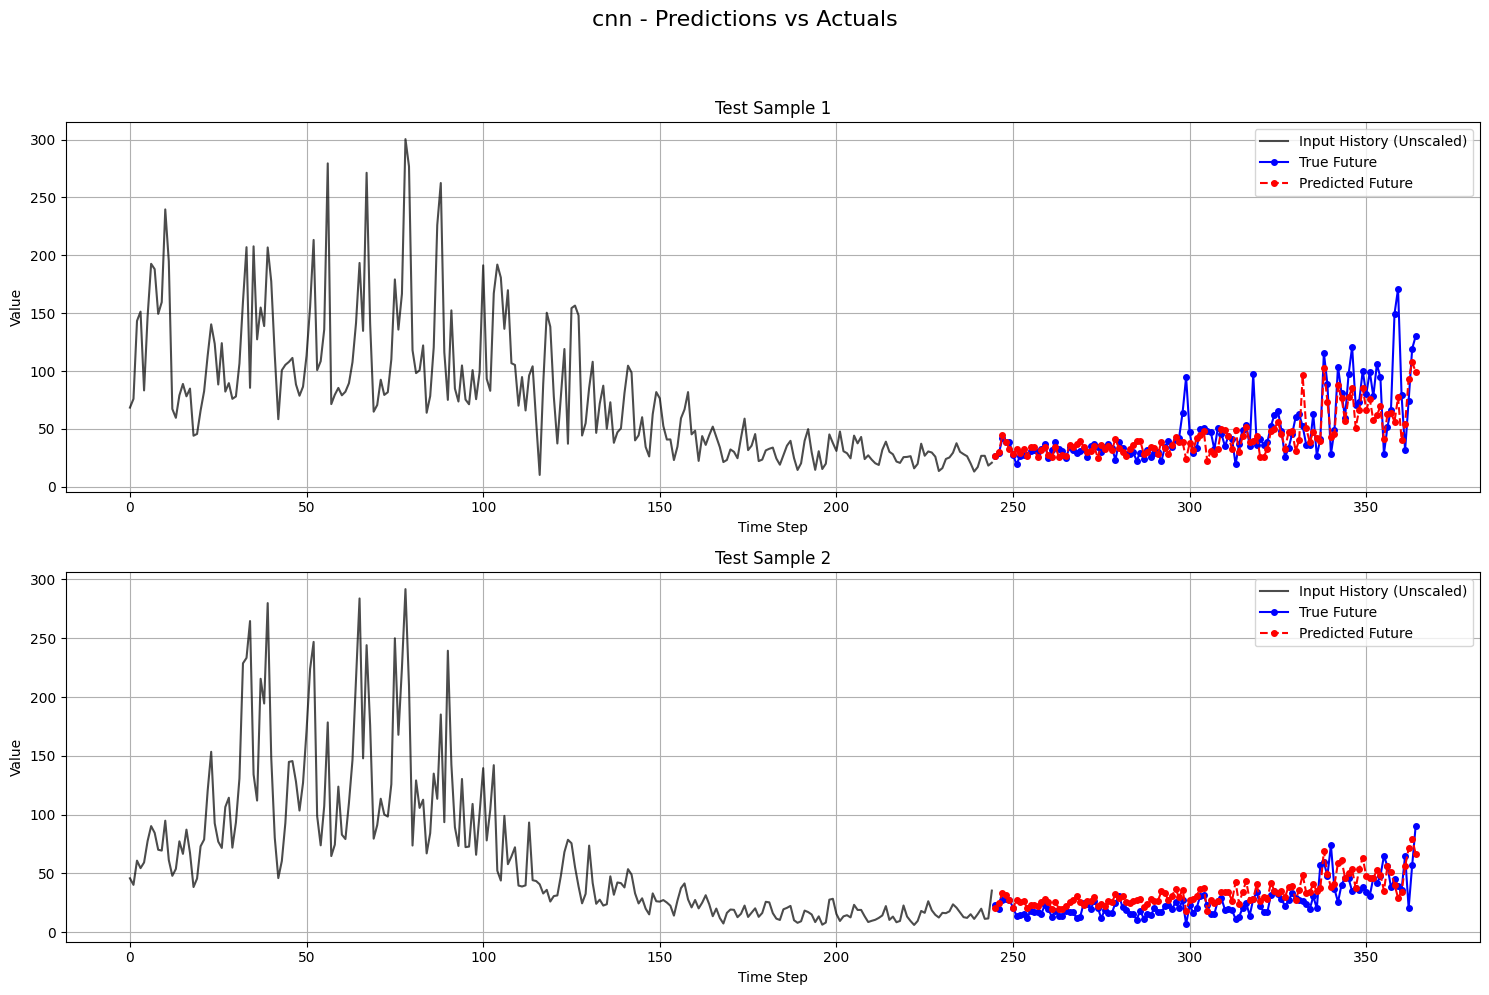

bigru Test Metrics: MSE=390.8340, MAE=13.1856, MAPE=34.45%


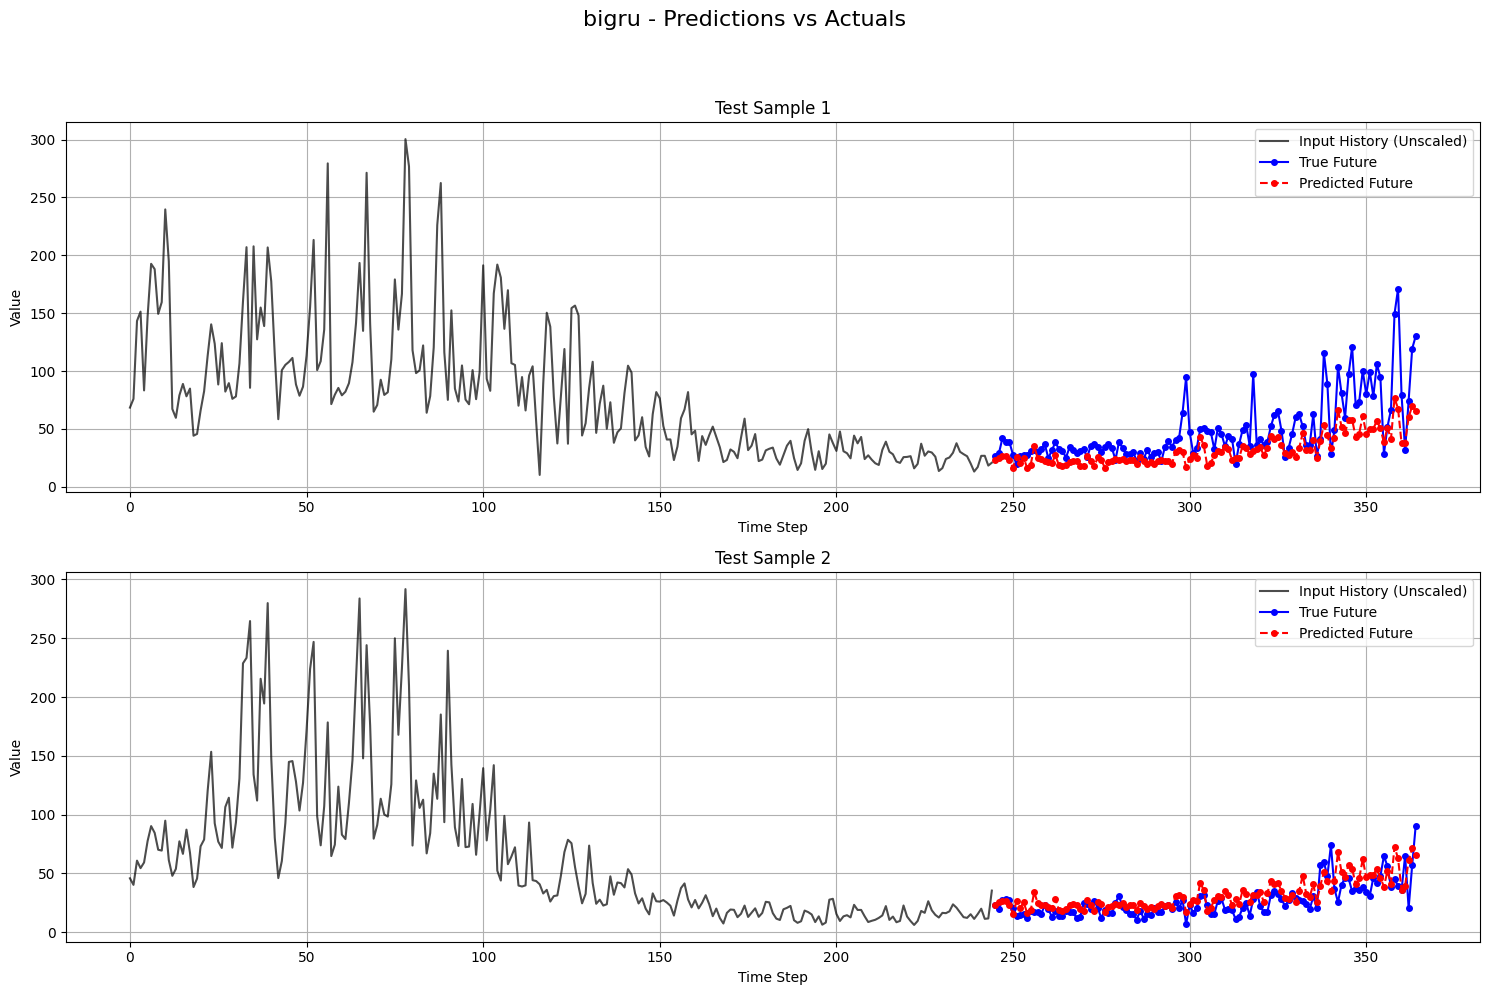

In [164]:
# 8. Train and Evaluate New Neural Networks
# Create and train CNN
cnn_model = create_cnn_model(data_shape, dates_shape)
cnn_model.fit(
    [X_train_data, X_train_dates], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Create and train BiGRU
bigru_model = create_bigru_model(data_shape, dates_shape)
bigru_model.fit(
    [X_train_data, X_train_dates], y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Evaluate new neural networks
print("\nEvaluating CNN:")
cnn_metrics, y_true_cnn, y_pred_cnn = evaluate_model(
    cnn_model, X_test_data, X_test_dates, y_test, y_scaler
)

print("\nEvaluating BiGRU:")
bigru_metrics, y_true_bigru, y_pred_bigru = evaluate_model(
    bigru_model, X_test_data, X_test_dates, y_test, y_scaler
)

print_result('cnn', cnn_metrics['mse'], cnn_metrics['mae'], cnn_metrics['mape'], y_true_cnn, y_pred_cnn)
print_result('bigru', bigru_metrics['mse'], bigru_metrics['mae'], bigru_metrics['mape'], y_true_bigru, y_pred_bigru)

### clasic


Training SVR...
SVR training complete

Training SGD...
SGD training complete

Training RandomForest...
RandomForest training complete

Training CatBoost...
CatBoost training complete

Evaluating SVR:
SVR Test Metrics: MSE=439.7853, MAE=12.5789, MAPE=30.25%


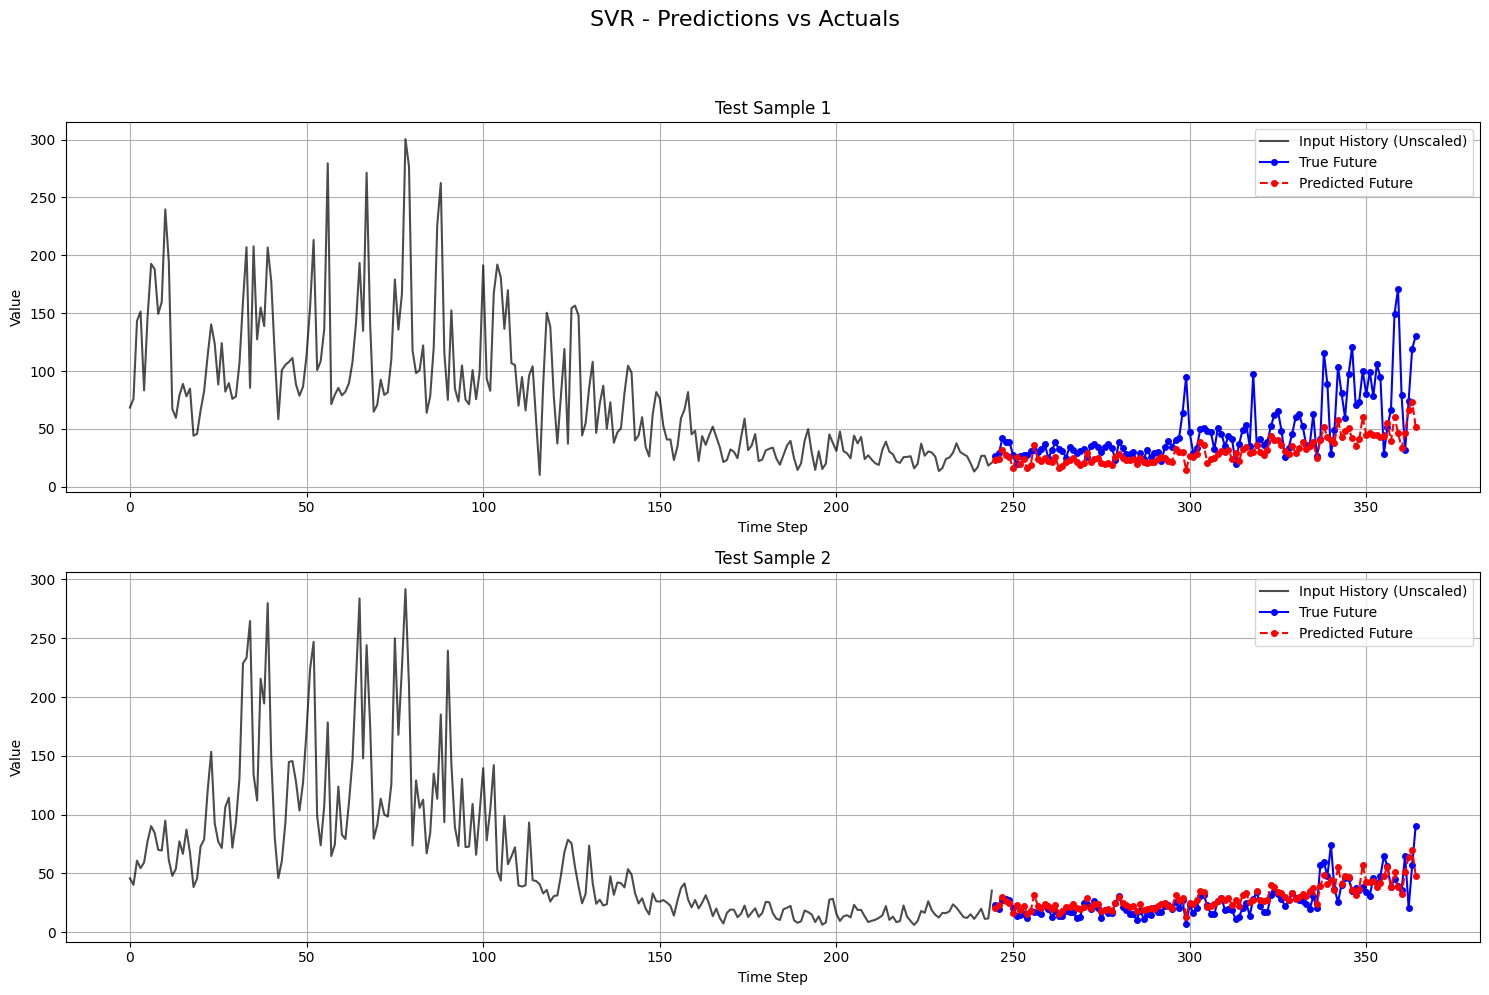


Evaluating SGD:
SGD Test Metrics: MSE=1892339787051011072.0000, MAE=543571463.8783, MAPE=1870282767.77%

Evaluating RandomForest:
RandomForest Test Metrics: MSE=265.6515, MAE=10.0269, MAPE=24.34%


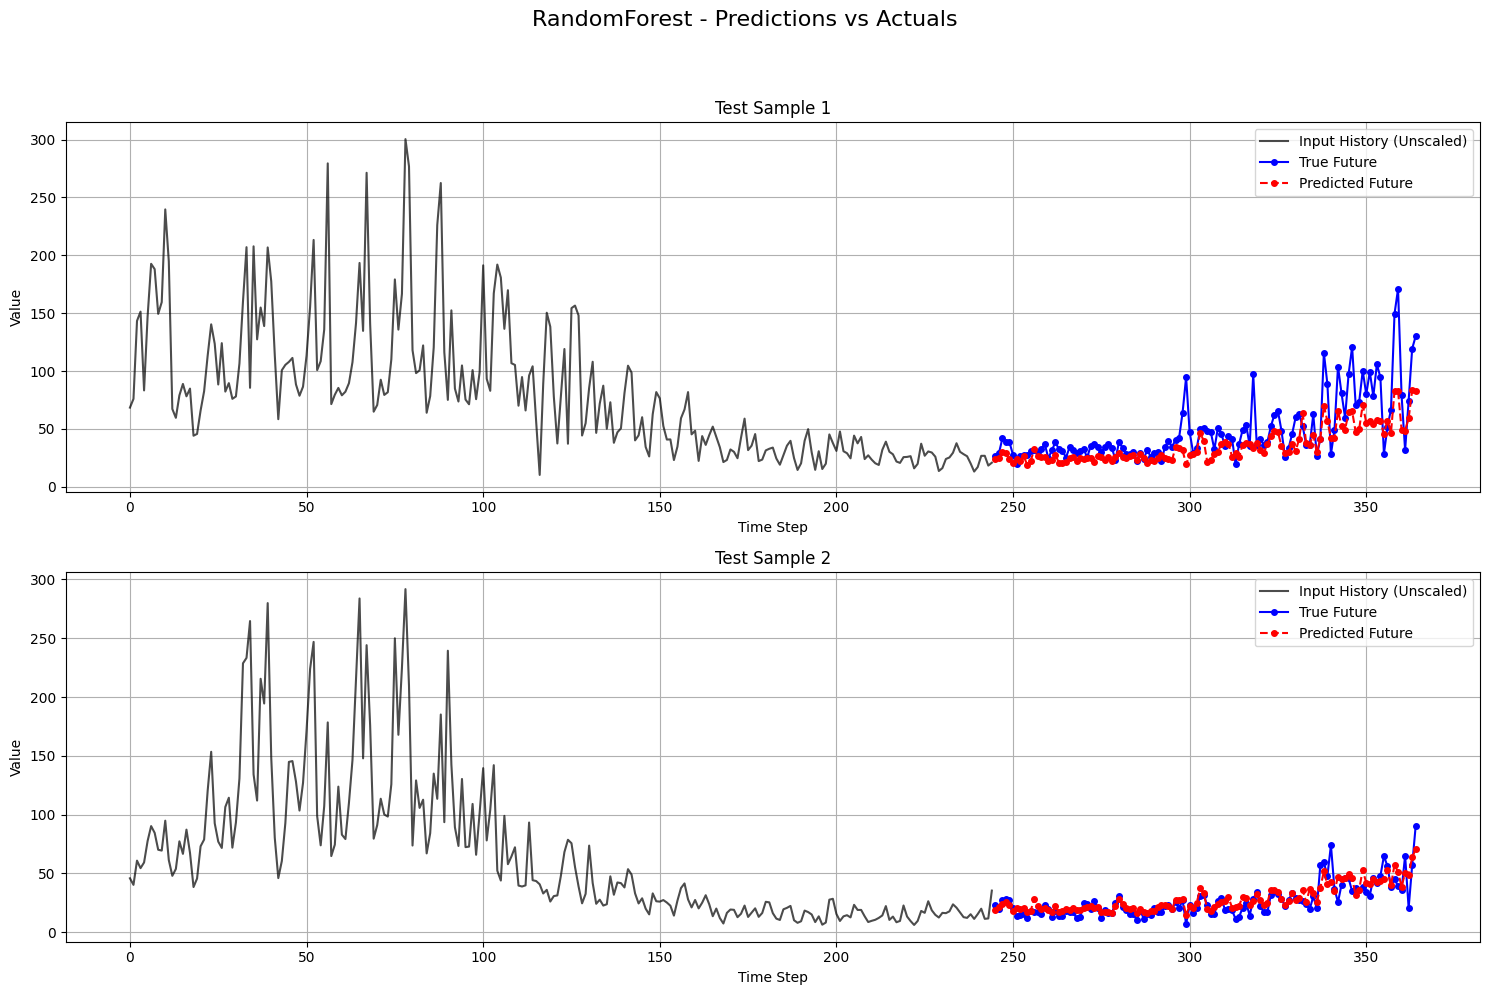


Evaluating CatBoost:
CatBoost Test Metrics: MSE=261.9113, MAE=9.9193, MAPE=25.39%


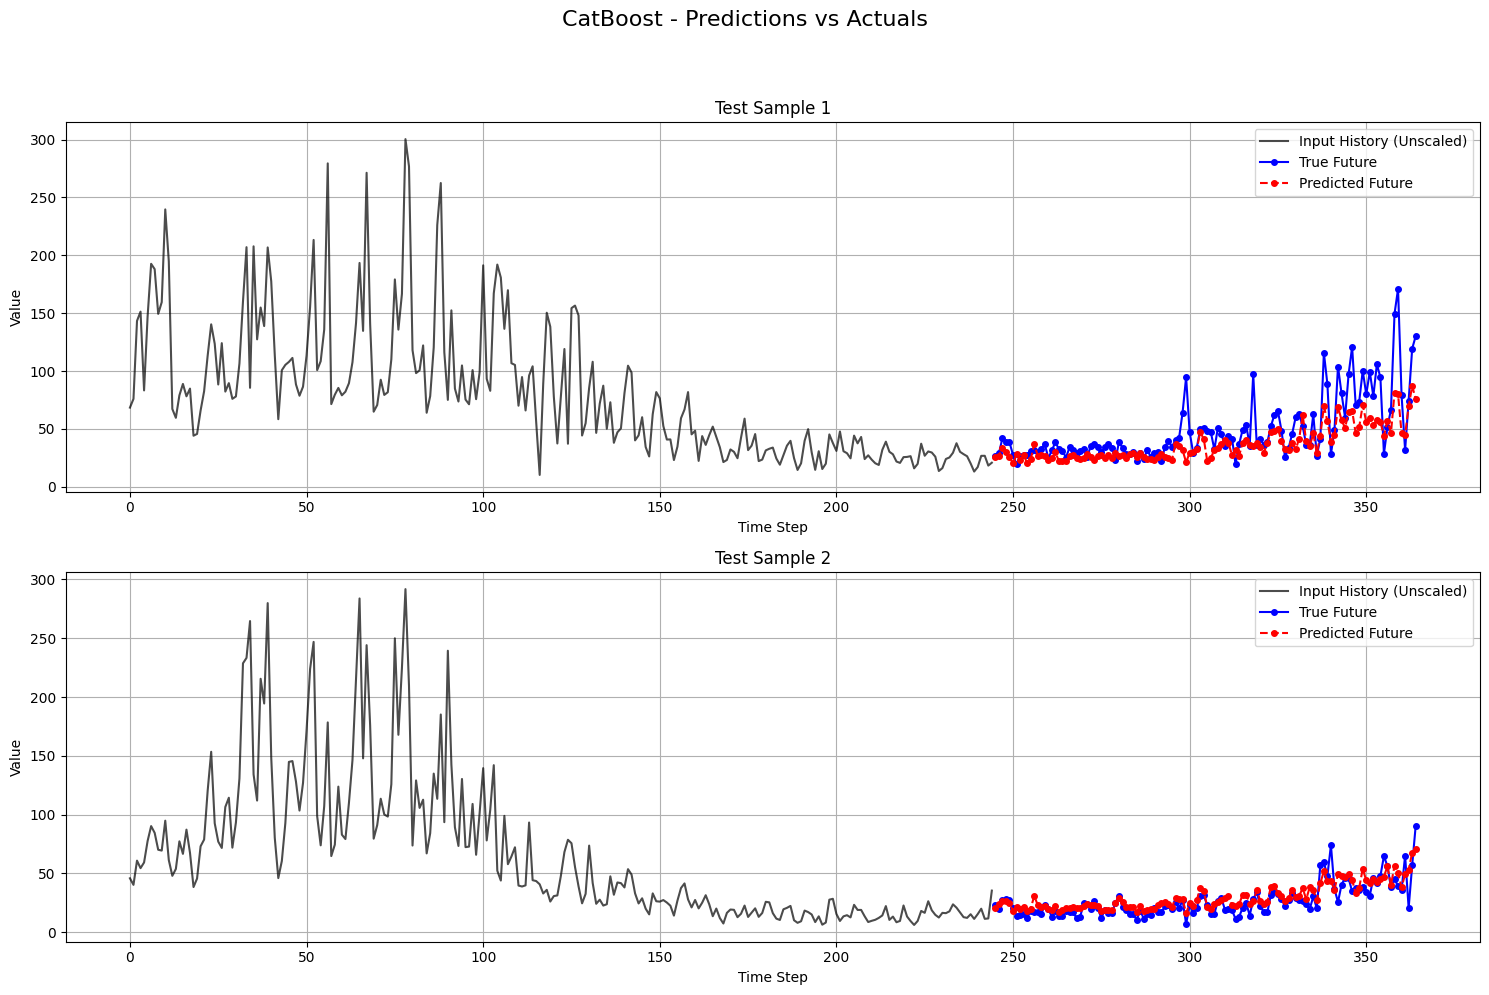

In [165]:
# Train all traditional models
traditional_models = train_traditional_models(X_train_flat, y_train)

# Evaluate traditional models
traditional_preds = {}
for name, model in traditional_models.items():
    print(f"\nEvaluating {name}:")
    pred = evaluate_traditional_model(
        model, X_test_flat, y_test, y_scaler, name
    )
    traditional_preds[name] = pred

In [115]:
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.base import clone
import numpy as np

# 1. Function to split training data into train/val sets by dataset ID
def split_train_val_by_dataset(train_samples, val_ratio=0.2, random_state=None):
    """
    Split training samples into train/validation sets grouped by dataset ID.
    
    Args:
        train_samples: Dictionary of training samples
        val_ratio: Ratio of datasets to use for validation
        random_state: Seed for reproducible splits
    
    Returns:
        new_train_samples, val_samples: Split datasets
    """
    # Extract unique dataset IDs from sample names (e.g., '1' from '1_1')
    dataset_ids = list(set([name.split('_')[0] for name in train_samples.keys()]))
    
    # Split dataset IDs while maintaining group integrity
    train_ids, val_ids = train_test_split(dataset_ids, 
                                        test_size=val_ratio,
                                        random_state=random_state)
    
    # Create new split samples dictionaries
    new_train_samples = {name: data for name, data in train_samples.items()
                        if name.split('_')[0] in train_ids}
    val_samples = {name: data for name, data in train_samples.items()
                  if name.split('_')[0] in val_ids}
    
    return new_train_samples, val_samples

# 2. Generic hyperparameter tuning function with grouped cross-validation
def tune_hyperparameters(model, param_grid, X_train, y_train, groups,
                        scoring='neg_mean_squared_error', cv_splits=5):
    """
    Perform grouped cross-validation for hyperparameter tuning.
    
    Args:
        model: Model object to tune
        param_grid: Dictionary of hyperparameters to search
        X_train: Training features
        y_train: Training targets
        groups: Group IDs for samples (dataset IDs)
        scoring: Evaluation metric
        cv_splits: Number of cross-validation folds
    
    Returns:
        best_model: Model trained with best parameters
        best_params: Dictionary of best parameters found
    """
    # Create grouped K-Fold cross-validator
    group_kfold = GroupKFold(n_splits=cv_splits)
    
    # Set up grid search with grouped cross-validation
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=group_kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    
    # Perform grid search with groups
    grid_search.fit(X_train, y_train, groups=groups)
    
    # Return best model and parameters
    return grid_search.best_estimator_, grid_search.best_params_

# 3. Function to prepare data with groups for cross-validation
def prepare_data_with_groups(samples_dict, data_scaler=None, y_scaler=None, fit_scalers=True):
    """
    Preprocess samples and return data with corresponding group IDs.
    
    Returns:
        X_flat: Flattened features
        y: Targets
        groups: Dataset IDs for each sample
        scalers: Tuple of (data_scaler, y_scaler)
    """
    # Preprocess samples
    (X_data, X_dates, y), data_scaler, y_scaler = preprocess_samples(
        samples_dict, data_scaler, y_scaler, fit_scalers
    )
    
    # Prepare traditional ML format
    X_flat = prepare_traditional_data(X_data, X_dates)
    
    # Extract group IDs (dataset IDs) from sample names
    groups = [name.split('_')[0] for name in samples_dict.keys()]
    
    return X_flat, y, groups, (data_scaler, y_scaler)

# Example usage ---------------------------------------------------------------
# Initial data split (keep test as is)
test_ids = ['1_2', '14_1']
test_samples = {name: data for name, data in data_samples.items() if name in test_ids}
original_train_samples = {name: data for name, data in data_samples.items() if name not in test_ids}

# Split train into train/val
import random
val_samples_ids = ['69_1', '69_2']
while val_samples_ids[0].split('_')[0] == val_samples_ids[1].split('_')[0]:
    val_samples_ids = random.sample(list(original_train_samples.keys()), 2) 
    print(val_samples_ids)

test_ids = ['1_2', '14_1']
val_samples = {name: data for name, data in original_train_samples.items() if name in val_samples_ids}
new_train_samples = {name: data for name, data in original_train_samples.items() if name not in val_samples_ids}

# Prepare data with groups
X_new_train, y_new_train, train_groups, scalers = prepare_data_with_groups(new_train_samples)
data_scaler, y_scaler = scalers

# Prepare validation data (using same scalers)
X_val, y_val, _, _ = prepare_data_with_groups(val_samples, *scalers, fit_scalers=False)

['5_2', '1_1']


In [116]:
new_train_samples.keys(), val_samples.keys(), test_samples.keys()

(dict_keys(['2_1', '2_2', '5_1', '6_1', '6_2', '104_1']),
 dict_keys(['1_1', '5_2']),
 dict_keys(['1_2', '14_1']))

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import GroupKFold
from functools import partial

def objective(trial, model_class, X, y, groups, n_splits=5):
    """Optuna objective function for hyperparameter optimization with grouped cross-validation"""
    # Suggest hyperparameters based on model type
    if model_class.__name__ == 'SVR':
        params = {
            'C': trial.suggest_float('C', 1e-2, 1e2, log=True),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
            'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly']),
            'epsilon': trial.suggest_float('epsilon', 0.01, 0.2)
        }
        model = MultiOutputRegressor(model_class(**params))
    elif model_class.__name__ == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
        }
        model = MultiOutputRegressor(model_class(**params, random_state=42))
    else:
        raise ValueError(f"Unsupported model class: {model_class}")

    # Grouped cross-validation
    group_kfold = GroupKFold(n_splits=n_splits)
    scores = []
    
    for train_idx, val_idx in group_kfold.split(X, y, groups):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = clone(model)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = np.mean((y_val - y_pred)**2)
        scores.append(mse)
    
    return np.mean(scores)

def tune_with_optuna(model_class, X_train, y_train, groups, 
                    n_trials=50, timeout=600, n_splits=4):
    """Optimize hyperparameters using Optuna with grouped cross-validation"""
    # Create study with TPESampler for efficient optimization
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42),
        pruner=optuna.pruners.HyperbandPruner()
    )
    
    # Partial function to pass additional arguments
    objective_func = partial(
        objective,
        model_class=model_class,
        X=X_train,
        y=y_train,
        groups=groups,
        n_splits=n_splits
    )
    
    study.optimize(objective_func, n_trials=n_trials, timeout=timeout, n_jobs=-1)
    
    # Retrain best model on full training data
    if model_class.__name__ == 'SVR':
        best_model = MultiOutputRegressor(model_class(**study.best_params))
    elif model_class.__name__ == 'RandomForestRegressor':
        best_model = MultiOutputRegressor(model_class(**study.best_params, random_state=42))
    best_model.fit(X_train, y_train)
    
    return best_model, study.best_params, study

# Example usage ---------------------------------------------------------------
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Prepare data (using previous split from train/val example)
X_new_train, y_new_train, train_groups, scalers = prepare_data_with_groups(new_train_samples)
data_scaler, y_scaler = scalers

[I 2025-04-24 13:21:37,483] A new study created in memory with name: no-name-f2b410d2-5152-49c4-be82-f631c69dbc4d
[I 2025-04-24 13:21:38,139] Trial 0 finished with value: 1.3001539282114911 and parameters: {'C': 0.31489116479568624, 'gamma': 'scale', 'kernel': 'rbf', 'epsilon': 0.039638958863878505}. Best is trial 0 with value: 1.3001539282114911.
[I 2025-04-24 13:21:38,590] Trial 1 finished with value: 1.3947988190763243 and parameters: {'C': 0.017073967431528128, 'gamma': 'scale', 'kernel': 'rbf', 'epsilon': 0.19428287191077892}. Best is trial 0 with value: 1.3001539282114911.
[I 2025-04-24 13:21:38,988] Trial 2 finished with value: 1.090829279592643 and parameters: {'C': 21.368329072358772, 'gamma': 'scale', 'kernel': 'poly', 'epsilon': 0.10970372201012518}. Best is trial 2 with value: 1.090829279592643.
[I 2025-04-24 13:21:39,820] Trial 3 finished with value: 1.351071933881756 and parameters: {'C': 0.5342937261279778, 'gamma': 'auto', 'kernel': 'poly', 'epsilon': 0.0796087502258014

Optimized SVR validation performance:
SVR (Optuna) Test Metrics: MSE=2487.7510, MAE=34.7599, MAPE=29.73%


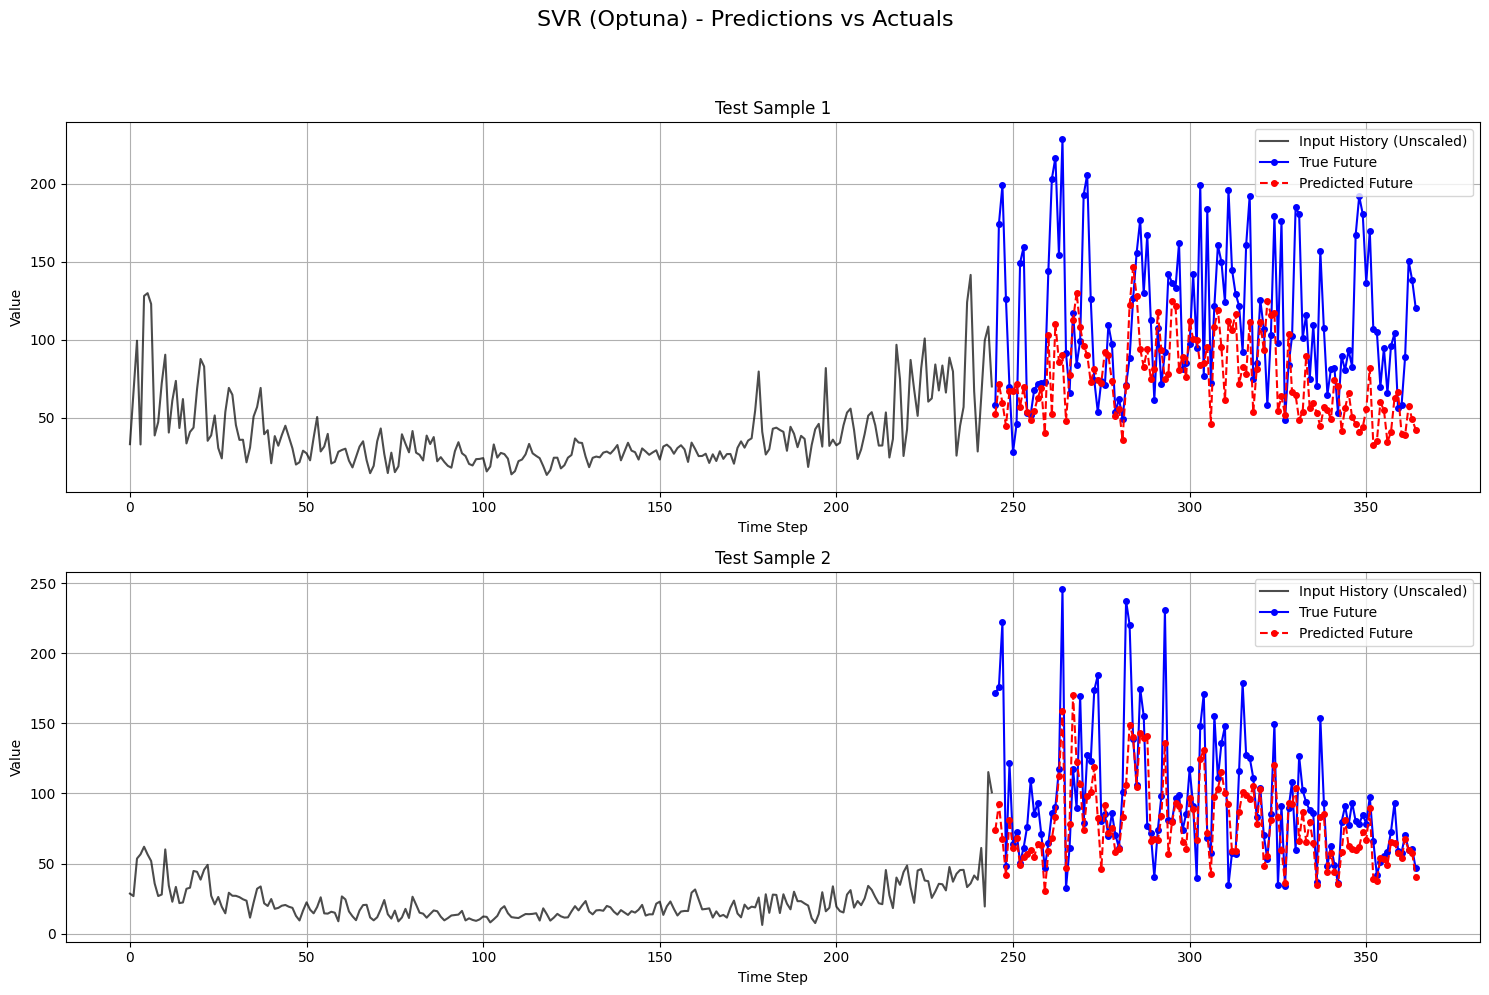


Optimized Random Forest validation performance:
RF (Optuna) Test Metrics: MSE=2575.5859, MAE=35.5329, MAPE=31.66%


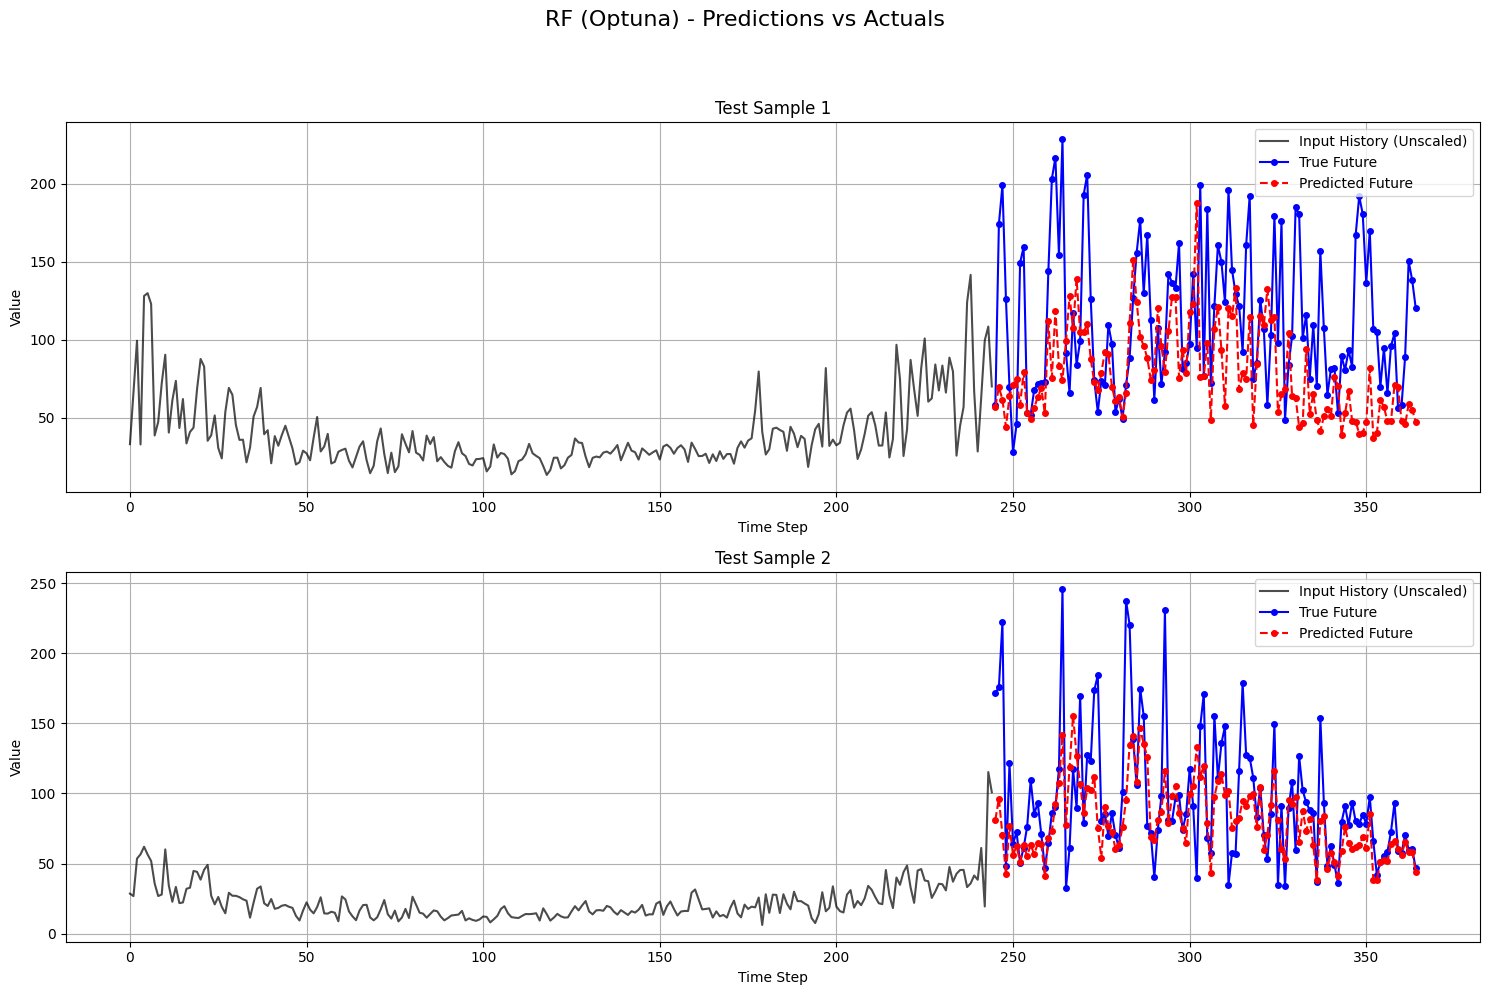

In [ ]:
# Tune SVR with Optuna
best_svr, svr_params, svr_study = tune_with_optuna(
    SVR,
    X_new_train,
    y_new_train,
    train_groups,
    n_trials=50,
    timeout=1200
)

# Tune Random Forest with Optuna
best_rf, rf_params, rf_study = tune_with_optuna(
    RandomForestRegressor,
    X_new_train,
    y_new_train,
    train_groups,
    n_trials=10,
    # timeout=900
)

# Visualization of optimization results
optuna.visualization.plot_optimization_history(svr_study)
optuna.visualization.plot_param_importances(svr_study)
optuna.visualization.plot_slice(svr_study)

# Evaluate on validation set
print("Optimized SVR validation performance:")
evaluate_traditional_model(best_svr, X_val, y_val, y_scaler, "SVR (Optuna)")

print("\nOptimized Random Forest validation performance:")
evaluate_traditional_model(best_rf, X_val, y_val, y_scaler, "RF (Optuna)")

# Save best parameters
best_params = {
    'SVR': svr_params,
    'RandomForest': rf_params
}

In [111]:
test_samples.keys(), val_samples.keys(), new_train_samples.keys()

(dict_keys(['1_2', '14_1']),
 dict_keys(['1_1', '6_1']),
 dict_keys(['1_2', '2_1', '2_2', '5_1', '5_2', '6_2', '14_1', '104_1']))

Optimized SVR validation performance:
SVR (Optuna) Test Metrics: MSE=1202.5552, MAE=25.1896, MAPE=30.04%


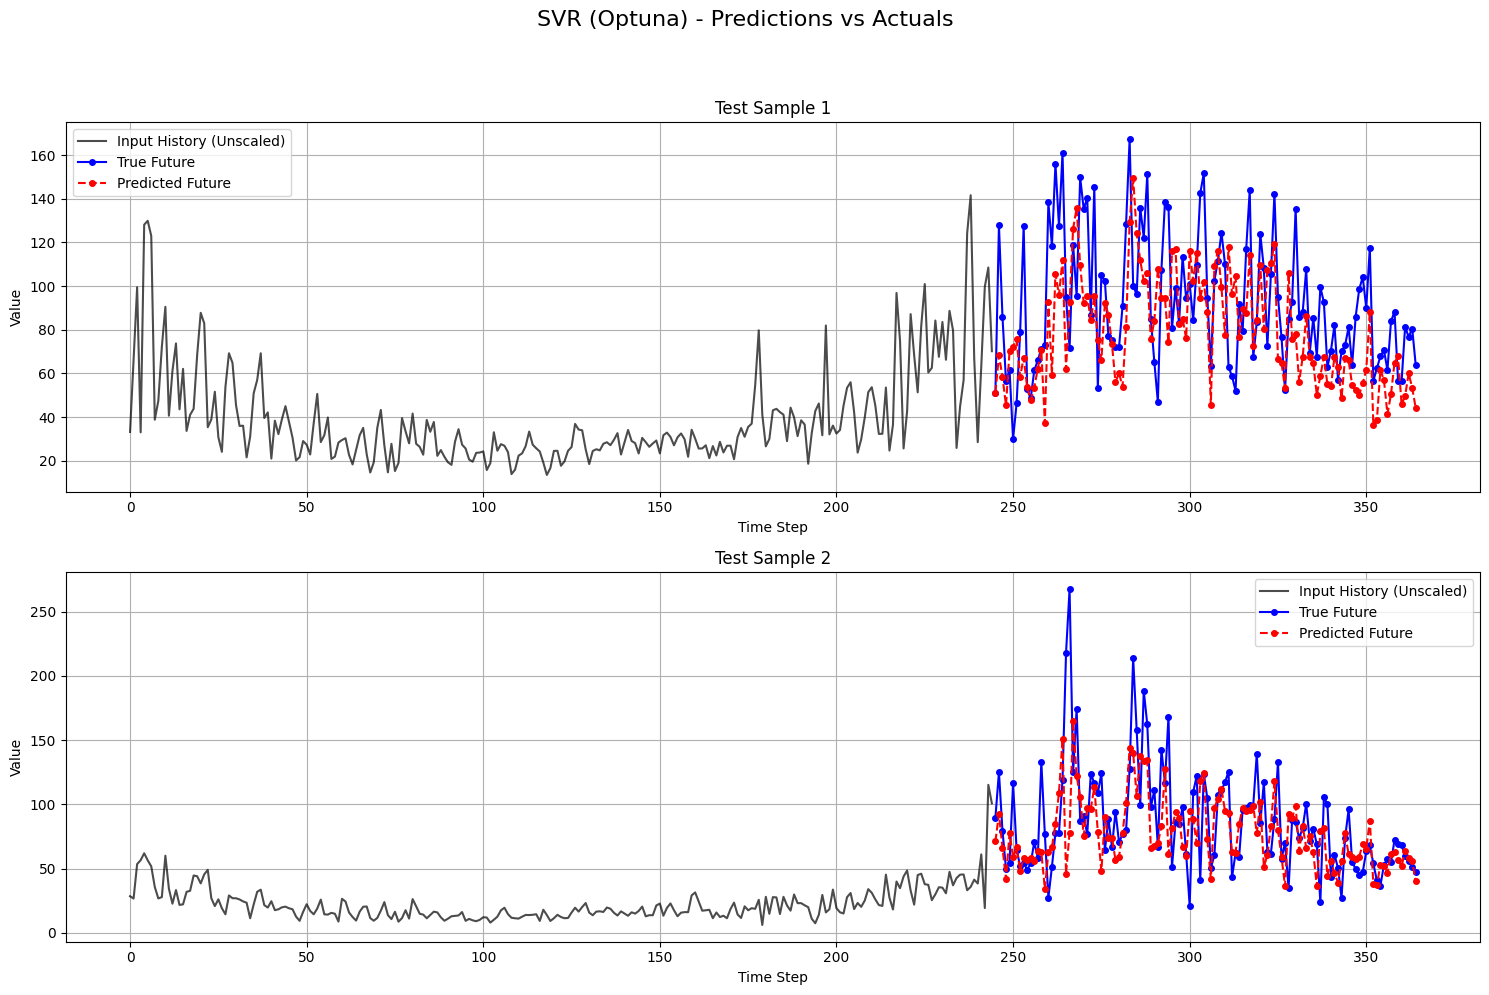


Optimized Random Forest validation performance:
RF (Optuna) Test Metrics: MSE=1061.3488, MAE=23.1948, MAPE=28.74%


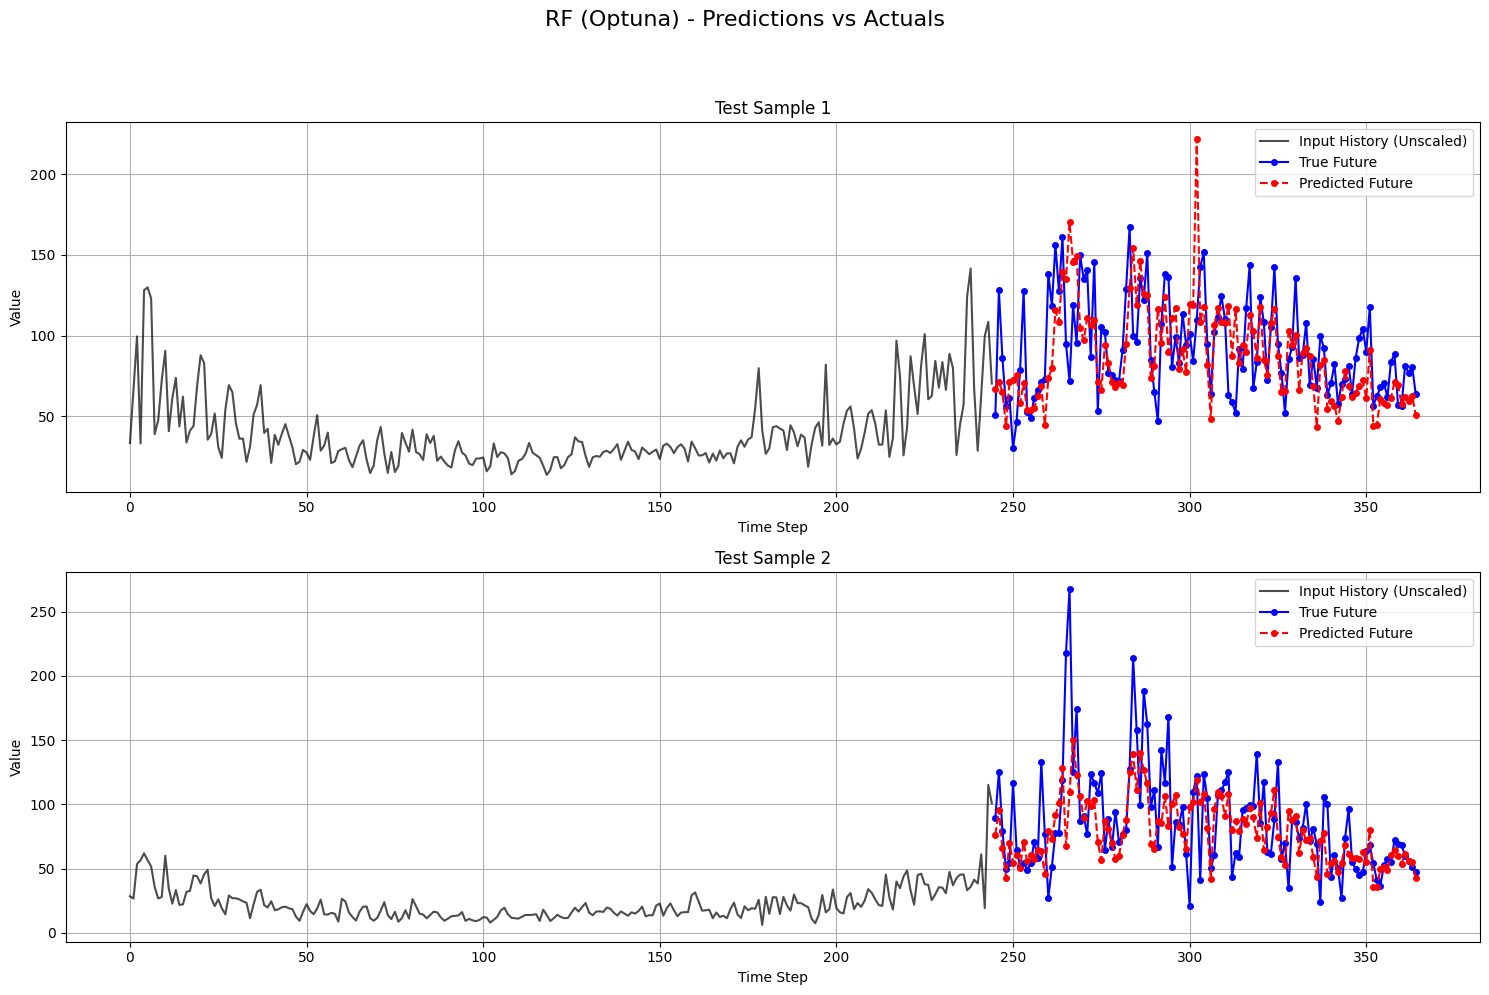

()

In [ ]:
print("Optimized SVR validation performance:")
evaluate_traditional_model(best_svr, X_test_flat, y_test, y_scaler, "SVR (Optuna)")

print("\nOptimized Random Forest validation performance:")
evaluate_traditional_model(best_rf, X_test_flat, y_test, y_scaler, "RF (Optuna)")
/

In [ ]:

# Define the filename where you want to save the model
model_name = 'rf'
model_filename = f'{month}_{model_name}_model.joblib'
model_folder = '../models_seq2seq/'
model = traditional_models['RandomForest']

# Save the TRAINED model object to the file
print(f"Saving model to {model_filename}...")
joblib.dump(model, model_folder+model_filename)
print("Model saved successfully.")

Saving model to nov_rf_model.joblib...
Model saved successfully.


## NeuralForecast

In [2]:
import pandas as pd

records = []

for uid, df_series in data_samples.items():
    df_series = df_series.rename(columns={df_series.columns[1]: 'y'})
    df_series = df_series[['full_date', 'y']].copy()
    df_series['unique_id'] = uid
    df_series = df_series.rename(columns={'full_date': 'ds'})
    records.append(df_series)

df_all = pd.concat(records, ignore_index=True)

In [3]:
test_ids = ['1_2', '14_1']
test_df = df_all[df_all['unique_id'].isin(test_ids)]
train_df = df_all[~df_all['unique_id'].isin(test_ids)]

<Axes: >

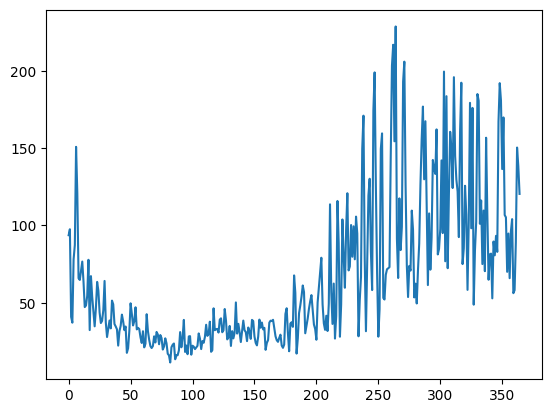

In [4]:
train_df[train_df['unique_id']=='1_1']['y'].plot()

In [5]:
horizon = 125
train_df = train_df.sort_values(['unique_id', 'ds'])

In [6]:
train_df

,ds,y,unique_id
3285,2019-03-16,39.425591,104_1
3286,2019-03-17,65.265278,104_1
3287,2019-03-18,49.719444,104_1
3288,2019-03-19,34.334260,104_1
3289,2019-03-20,65.029167,104_1
...,...,...,...
2915,2019-03-11,53.529576,6_2
2916,2019-03-12,68.687065,6_2
2917,2019-03-13,56.190410,6_2
2918,2019-03-14,55.816092,6_2


In [7]:
from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

train_df['ds'] = pd.to_datetime(train_df['ds']) 
test_df['ds'] = pd.to_datetime(test_df['ds']) 
train_dataset, indices, dates, ds_arr = TimeSeriesDataset.from_df(
    df=train_df,
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)
test_dataset, indices, dates, ds_arr = TimeSeriesDataset.from_df(
    df=test_df,
    id_col="unique_id",
    time_col="ds",
    target_col="y"
)

c:\Users\77019\pyver\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-17 17:57:19,573	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-17 17:57:19,997	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
C:\Users\77019\AppData\Local\Temp\ipykernel_1856\300558927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['ds'] = pd.to_datetime(test_df['ds'])


In [14]:
from ray import tune

def optuna_config(trial):
    return {
        # "input_size_multiplier": trial.suggest_categorical("input_size_multiplier", [-1, 4, 16, 64]),
        # "inference_input_size_multiplier": -1,  # single value, no need to tune
        "h": None,  # set externally
        "encoder_hidden_size": trial.suggest_categorical("encoder_hidden_size", [16, 32, 64, 128]),
        "encoder_n_layers": trial.suggest_int("encoder_n_layers", 1, 3),  # randint(1, 4) → [1, 2, 3]
        # "context_size": trial.suggest_categorical("context_size", [5, 10, 50]),
        "decoder_hidden_size": trial.suggest_categorical("decoder_hidden_size", [16, 32, 64, 128]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32]),
        "loss": None,  # set externally
        "random_seed": trial.suggest_int("random_seed", 1, 19),  # randint(1, 20) → [1, 2, ..., 19]
        'start_padding_enabled': True,
        'input_size': 240
    }

model_lstm = AutoLSTM(h=horizon, num_samples=20, backend='optuna', config=optuna_config)

model_lstm.fit(dataset=train_dataset, distributed_config=None)
y_hat = model_lstm.predict(dataset=train_dataset)

[I 2025-04-16 14:25:48,617] A new study created in memory with name: no-name-38a83a40-5a44-47cf-abd1-3b9a2cab23c3
Seed set to 16
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 21.4 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:26:59,295] Trial 0 finished with value: 37.10231399536133 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 3, 'decoder_hidden_size': 128, 'learning_rate': 0.032856186219968574, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 16}. Best is trial 0 with value: 37.10231399536133.
Seed set to 18
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:27:32,400] Trial 1 finished with value: 35.79218673706055 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.0025216951779921397, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 18}. Best is trial 1 with value: 35.79218673706055.
Seed set to 2
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 545    | train
-------------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:27:47,944] Trial 2 finished with value: 38.1959228515625 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 16, 'learning_rate': 0.0027815865579178156, 'max_steps': 500, 'batch_size': 16, 'random_seed': 2}. Best is trial 1 with value: 35.79218673706055.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 331 K  | train
4 | mlp_decoder  | MLP           | 8.3 K  | train
-------------------------------------------------------
339 K     Trainable params
0         Non-trainable params
339 K     Total params
1.358     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:32:24,340] Trial 3 finished with value: 47.95771789550781 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 3, 'decoder_hidden_size': 64, 'learning_rate': 0.002326927323739746, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 19}. Best is trial 1 with value: 35.79218673706055.
Seed set to 14
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 8.4 K  | train
-------------------------------------------------------
58.9 K    Trainable params
0         Non-trainable params
58.9 K    Total params
0.236     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:33:47,364] Trial 4 finished with value: 40.1839485168457 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 2, 'decoder_hidden_size': 128, 'learning_rate': 0.008896625462952362, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14}. Best is trial 1 with value: 35.79218673706055.
Seed set to 11
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 199 K  | train
4 | mlp_decoder  | MLP           | 4.2 K  | train
-------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.813     Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:35:18,008] Trial 5 finished with value: 42.299163818359375 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 2, 'decoder_hidden_size': 32, 'learning_rate': 0.00035923063734740656, 'max_steps': 500, 'batch_size': 32, 'random_seed': 11}. Best is trial 1 with value: 35.79218673706055.
Seed set to 18
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 5.6 K  | train
4 | mlp_decoder  | MLP           | 1.2 K  | train
-------------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:35:59,894] Trial 6 finished with value: 59.40221405029297 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 3, 'decoder_hidden_size': 64, 'learning_rate': 0.05197961523434381, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 18}. Best is trial 1 with value: 35.79218673706055.
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 1.2 K  | train
4 | mlp_decoder  | MLP           | 289    | train
-------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:36:11,591] Trial 7 finished with value: 44.047584533691406 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 1, 'decoder_hidden_size': 16, 'learning_rate': 0.05688754580972728, 'max_steps': 500, 'batch_size': 32, 'random_seed': 1}. Best is trial 1 with value: 35.79218673706055.
Seed set to 14
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 5.6 K  | train
4 | mlp_decoder  | MLP           | 577    | train
-------------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.025     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:36:32,968] Trial 8 finished with value: 39.62746047973633 and parameters: {'encoder_hidden_size': 16, 'encoder_n_layers': 3, 'decoder_hidden_size': 32, 'learning_rate': 0.020954595879021116, 'max_steps': 500, 'batch_size': 16, 'random_seed': 14}. Best is trial 1 with value: 35.79218673706055.
Seed set to 5
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 67.1 K | train
4 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
83.7 K    Trainable params
0         Non-trainable params
83.7 K    Total params
0.335     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:38:04,674] Trial 9 finished with value: 38.4451789855957 and parameters: {'encoder_hidden_size': 128, 'encoder_n_layers': 1, 'decoder_hidden_size': 128, 'learning_rate': 0.013417981999407387, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 5}. Best is trial 1 with value: 35.79218673706055.
Seed set to 8
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total esti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:38:35,082] Trial 10 finished with value: 48.39142990112305 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.00012451267263749796, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 8}. Best is trial 1 with value: 35.79218673706055.
Seed set to 16
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:39:26,140] Trial 11 finished with value: 39.38453674316406 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 2, 'decoder_hidden_size': 128, 'learning_rate': 0.0010196536696338843, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 16}. Best is trial 1 with value: 35.79218673706055.
Seed set to 11
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 21.4 K | train
4 | mlp_decoder  | MLP           | 4.4 K  | train
-------------------------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:40:34,235] Trial 12 finished with value: 41.37432098388672 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 3, 'decoder_hidden_size': 128, 'learning_rate': 0.0053167859290256065, 'max_steps': 1000, 'batch_size': 32, 'random_seed': 11}. Best is trial 1 with value: 35.79218673706055.
Seed set to 16
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 12.9 K | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:41:22,243] Trial 13 finished with value: 36.595523834228516 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 2, 'decoder_hidden_size': 32, 'learning_rate': 0.001051266816424403, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 16}. Best is trial 1 with value: 35.79218673706055.
Seed set to 14
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 50.4 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.210     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:42:37,981] Trial 14 finished with value: 45.70823669433594 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 2, 'decoder_hidden_size': 32, 'learning_rate': 0.000800195830746358, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 14}. Best is trial 1 with value: 35.79218673706055.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total es

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:43:08,287] Trial 15 finished with value: 35.413780212402344 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.0006369104104086991, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 19}. Best is trial 15 with value: 35.413780212402344.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:43:38,550] Trial 16 finished with value: 45.90483093261719 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.00026878003777051424, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 19}. Best is trial 15 with value: 35.413780212402344.
Seed set to 8
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:44:09,103] Trial 17 finished with value: 37.99806213378906 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.00046641345033452514, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 8}. Best is trial 15 with value: 35.413780212402344.
Seed set to 17
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 17.2 K | train
4 | mlp_decoder  | MLP           | 2.1 K  | train
-------------------------------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
[I 2025-04-16 14:44:31,617] Trial 18 finished with value: 39.21652603149414 and parameters: {'encoder_hidden_size': 64, 'encoder_n_layers': 1, 'decoder_hidden_size': 32, 'learning_rate': 0.0017818610160711425, 'max_steps': 500, 'batch_size': 16, 'random_seed': 17}. Best is trial 15 with value: 35.413780212402344.
Seed set to 13
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 2.2 K  | train
-------------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-04-16 14:45:03,561] Trial 19 finished with value: 40.2962532043457 and parameters: {'encoder_hidden_size': 32, 'encoder_n_layers': 1, 'decoder_hidden_size': 64, 'learning_rate': 0.00012479469404605791, 'max_steps': 1000, 'batch_size': 16, 'random_seed': 13}. Best is trial 15 with value: 35.413780212402344.
Seed set to 19
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 4.5 K  | train
4 | mlp_decoder  | MLP           | 1.1 K  | train
-------------------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
y_pred_test = model_lstm.predict(test_dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
forecast_dict = {}
for i in range(len(y_pred_test)//horizon):
    forecast_dict[test_ids[i]] = y_pred_test[i*horizon:(i+1)*horizon]

In [64]:
def count_metrics(model_name, params, test_df, y_hat, test_lengths):
    test_df_copy = test_df.copy()
    test_df_copy['forecast'] = y_hat

    error_dict = {}
    for test_length in test_lengths:
        eval_subset = test_df_copy.iloc[:test_length]  # Take subset for evaluation
        error_dict[f"test_{test_length}_days"] = mape_met(eval_subset['y'].values,  eval_subset['forecast'].values)

    monthly_error_dict = defaultdict(dict)
    test_df_copy['year'] = test_df_copy['ds'].dt.year
    test_df_copy['month'] = test_df_copy['ds'].dt.month

    # Group by year and month and calculate MAPE for each group
    grouped = test_df_copy.groupby(['year', 'month'])
    for (year, month), group in grouped:
        if not group.empty:
            monthly_error_dict[year][month] = mape_met(group['y'].values, group['forecast'].values)

    return {
        "Model": model_name,
        **error_dict,  # Expand error dictionary into separate columns
        **monthly_error_dict,
        "preds": test_df_copy['forecast'].values,
        "params": params,
    }

In [ ]:
count_metrics('lstm', model_lstm.model.hparams, test_df, y_hat, test_lengths)

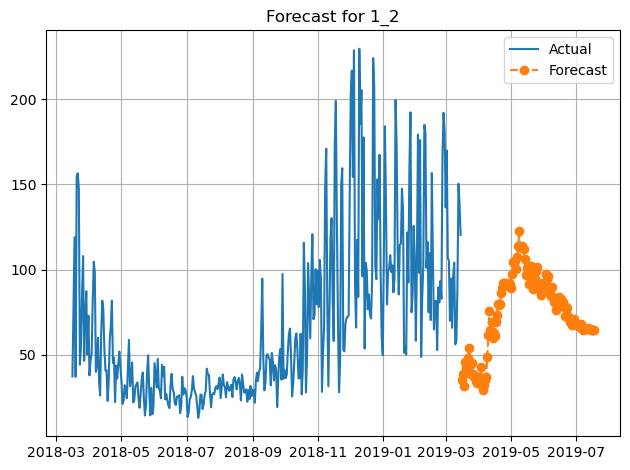

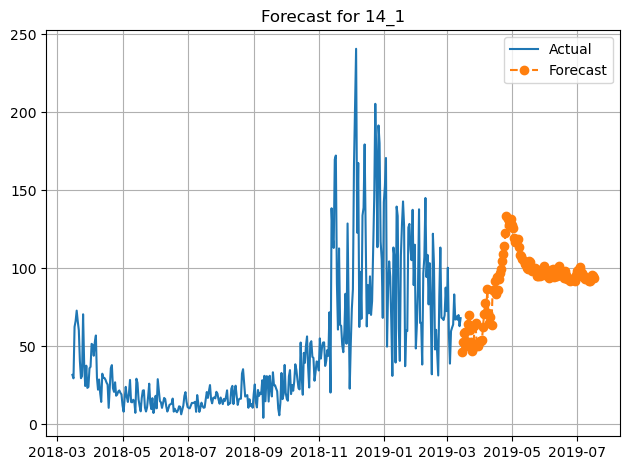

In [51]:
import matplotlib.pyplot as plt

for uid in test_df['unique_id'].unique():
    uid_test_df = test_df[test_df['unique_id'] == uid].copy()
    actual_data = uid_test_df['y']
    actual_dates = pd.to_datetime(uid_test_df['ds'])
    
    # Find the last date in the actual data
    last_date = pd.to_datetime(actual_dates.max())
    
    # Generate future dates based on your frequency (daily assumed here)
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon)
    
    # Get the corresponding forecasts
    predicted_values = forecast_dict[uid]

    # Plot actual data
    plt.figure()
    plt.plot(actual_dates, actual_data, label='Actual')
    
    # Plot forecasts
    plt.plot(future_dates, predicted_values, label='Forecast', linestyle='--', marker='o')
    
    plt.title(f"Forecast for {uid}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
y_pred_test.shape

(250, 1)

In [17]:
y_hat.shape

(1000, 1)

In [15]:
from neuralforecast.auto import AutoMLP

def optuna_config(trial):
    return {
        # 🔒 Fixed values
        "start_padding_enabled": True,
        "input_size": trial.suggest_int("num_layers", 2, 240),

        # 🔧 Tuned values
        "step_size": trial.suggest_categorical("step_size", [1, horizon]),
        "hidden_size": trial.suggest_categorical("hidden_size", [256, 512, 1024]),
        "num_layers": trial.suggest_int("num_layers", 2, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical("scaler_type", [None, "robust", "standard"]),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [128, 256, 512, 1024]),
        "loss": None,
        "random_seed": trial.suggest_int("random_seed", 1, 19),
    }
model_mlp = AutoMLP(
    h=horizon,
    backend="optuna",
    config=optuna_config,
    num_samples=20,
)
